<a href="https://colab.research.google.com/github/ArpitaGupta14/Intrusion-Detection-System/blob/main/DeepLearning_IDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# XAI
import shap
try:
    from lime import lime_tabular
    LIME_AVAILABLE = True
except:
    LIME_AVAILABLE = False

# Persistence
# Installing joblib if not already installed
try:
    import joblib
except ImportError:
    !pip install joblib
    import joblib


In [ ]:
# Load dataset
data_path = "/content/02-14-2018.csv"
df = pd.read_csv(data_path)

# Basic info
print("Shape:", df.shape)
display(df.head())
df.info()

Shape: (18936, 80)


,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,14/02/2018 08:31:01,112641719,3,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,56320859.5,139.300036,56320958.0,56320761.0,Benign
1,0,0,14/02/2018 08:33:50,112641466,3,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,56320733.0,114.551299,56320814.0,56320652.0,Benign
2,0,0,14/02/2018 08:36:39,112638623,3,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,56319311.5,301.934596,56319525.0,56319098.0,Benign
3,22,6,14/02/2018 08:40:13,6453966,15,10,1239,2273,744,0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign
4,22,6,14/02/2018 08:40:23,8804066,14,11,1143,2209,744,0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18936 entries, 0 to 18935
Data columns (total 80 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Dst Port           18936 non-null  int64  
 1   Protocol           18936 non-null  int64  
 2   Timestamp          18936 non-null  object 
 3   Flow Duration      18936 non-null  int64  
 4   Tot Fwd Pkts       18936 non-null  int64  
 5   Tot Bwd Pkts       18936 non-null  int64  
 6   TotLen Fwd Pkts    18936 non-null  int64  
 7   TotLen Bwd Pkts    18936 non-null  int64  
 8   Fwd Pkt Len Max    18936 non-null  int64  
 9   Fwd Pkt Len Min    18936 non-null  int64  
 10  Fwd Pkt Len Mean   18936 non-null  float64
 11  Fwd Pkt Len Std    18936 non-null  float64
 12  Bwd Pkt Len Max    18936 non-null  int64  
 13  Bwd Pkt Len Min    18936 non-null  int64  
 14  Bwd Pkt Len Mean   18936 non-null  float64
 15  Bwd Pkt Len Std    18936 non-null  float64
 16  Flow Byts/s        189

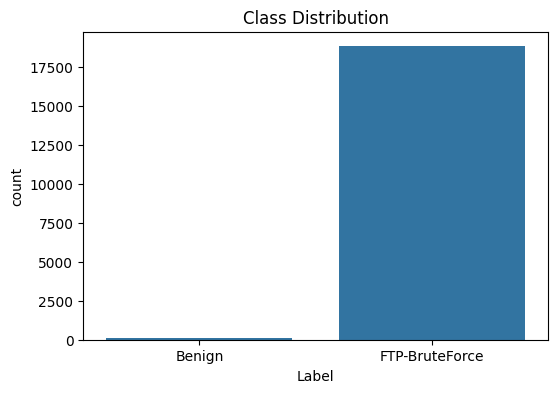

Fwd PSH Flags        1
Bwd PSH Flags        1
Fwd URG Flags        1
Bwd URG Flags        1
Fwd Header Len       1
Bwd Header Len       1
Fwd Pkts/s           1
Bwd Pkts/s           1
Pkt Len Min          1
Pkt Len Max          1
Pkt Len Mean         1
Pkt Len Std          1
Pkt Len Var          1
FIN Flag Cnt         1
SYN Flag Cnt         1
RST Flag Cnt         1
Subflow Fwd Byts     1
Subflow Bwd Pkts     1
Subflow Bwd Byts     1
Init Fwd Win Byts    1
dtype: int64


In [ ]:
# EDA
plt.figure(figsize=(6,4))
sns.countplot(x=df['Label'])
plt.title("Class Distribution")
plt.show()

# Missing values check
print(df.isnull().sum().sort_values(ascending=False).head(20))

data processing


In [ ]:
# Drop irrelevant columns (example: Timestamp)
if 'Timestamp' in df.columns:
    df = df.drop(columns=['Timestamp'])

# replace infinity value as null value
df = df.replace(["Infinity", "infinity"], np.inf)
df = df.replace([np.inf, -np.inf], np.nan)

# drop all null values
df.dropna(inplace=True)

target = 'Label'
X = df.drop(columns=[target])
y = df[target]

# Encode target variable y
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Identify numeric & categorical features
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]


In [ ]:
# Preprocess
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
    # OneHotEncoder could be added if you have categorical features
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ],
    remainder='drop')
# Encode categorical features if any
df = pd.get_dummies(df, drop_first=True)


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numeric data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Machine Learning Models — Decision Tree & XGBoost¶


In [ ]:
# Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print("Decision Tree Report:")
print(classification_report(y_test, y_pred_dt))

Decision Tree Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00      3767

    accuracy                           1.00      3787
   macro avg       1.00      1.00      1.00      3787
weighted avg       1.00      1.00      1.00      3787



In [ ]:
# XGBoost Classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, base_score=0.5)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("XGBoost Report:")
print(classification_report(y_test, y_pred_xgb))


XGBoost Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       1.00      1.00      1.00      3767

    accuracy                           1.00      3787
   macro avg       1.00      0.97      0.99      3787
weighted avg       1.00      1.00      1.00      3787



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [06:17:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Deep Learning Model — CNN

In [ ]:
# CNN expects 3D input (samples, timesteps, features)
X_train_cnn = np.expand_dims(X_train, axis=2)
X_test_cnn = np.expand_dims(X_test, axis=2)

cnn_model = keras.Sequential([
    layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1],1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(64, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = cnn_model.fit(X_train_cnn, y_train, validation_split=0.2, epochs=5, batch_size=256, verbose=1)
cnn_eval = cnn_model.evaluate(X_test_cnn, y_test, verbose=0)
print("CNN Test Accuracy:", cnn_eval[1])

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9200 - loss: 0.4320 - val_accuracy: 1.0000 - val_loss: 0.0038
Epoch 2/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 1.0000 - loss: 0.0054 - val_accuracy: 1.0000 - val_loss: 2.8480e-04
Epoch 3/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 8.5532e-05
Epoch 4/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9999 - loss: 9.5955e-04 - val_accuracy: 1.0000 - val_loss: 2.3434e-05
Epoch 5/5
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 1.0000 - loss: 4.1263e-04 - val_accuracy: 1.0000 - val_loss: 7.4072e-06
CNN Test Accuracy: 1.0


In [ ]:
# SHAP for XGBoost
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test[:200])
shap.summary_plot(shap_values, X_test[:200], show=False)
plt.show()

# SHAP for CNN using KernelExplainer
try:
    background = shap.sample(X_train[:500], 100)
    f = lambda inp: cnn_model.predict(np.expand_dims(inp, axis=2), verbose=0).flatten()
    explainer_cnn = shap.KernelExplainer(f, background)
    shap_vals = explainer_cnn.shap_values(X_test[:50], nsamples=50)
    shap.summary_plot(shap_vals, X_test[:50], show=False)
    plt.show()
except Exception as e:
    print("SHAP CNN skipped:", e)
    # LIME
if LIME_AVAILABLE:
    try:
        explainer = lime_tabular.LimeTabularExplainer(
            training_data=X_train,
            feature_names=df.drop(columns=[target]).columns.tolist(),
            class_names=['Normal','Attack'],
            discretize_continuous=True
        )
        exp = explainer.explain_instance(X_test[0], xgb.predict_proba, num_features=10)
        exp.show_in_notebook(show_table=True)
    except Exception as e:
        print("LIME skipped:", e)


ValueError: could not convert string to float: '[5E-1]'

SHAP XGBoost skipped: name 'xgb_model' is not defined


  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=9.876e-05, with an active set of 9 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(


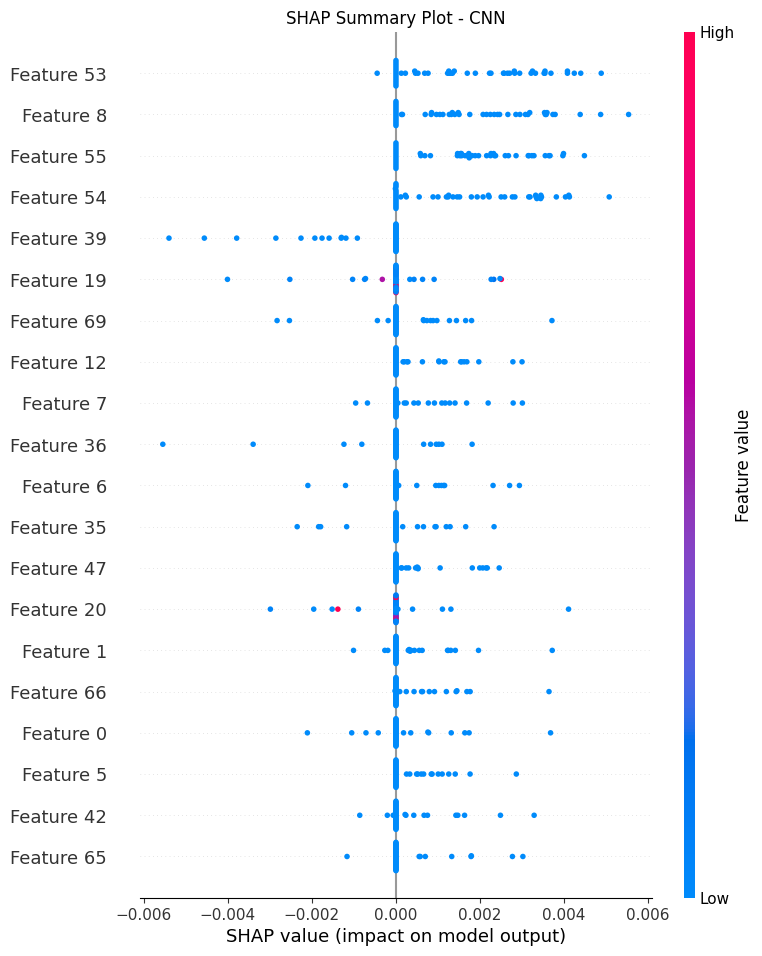

LIME not installed, skipping LIME section...


In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# === SHAP for XGBoost ===
try:
    # Ensure you’re using the trained model object
    # Replace xgb_model with your actual trained model variable
    explainer = shap.TreeExplainer(xgb_model.get_booster())  # robust option
    shap_values = explainer.shap_values(X_test[:200])

    shap.summary_plot(shap_values, X_test[:200], show=False)
    plt.title("SHAP Summary Plot - XGBoost")
    plt.show()

except Exception as e:
    print("SHAP XGBoost skipped:", e)

# === SHAP for CNN using KernelExplainer ===
try:
    # Background samples (for approximate SHAP values)
    background = shap.sample(X_train[:500], 100)

    # Define prediction function for SHAP
    f = lambda inp: cnn_model.predict(np.expand_dims(inp, axis=2), verbose=0).flatten()

    explainer_cnn = shap.KernelExplainer(f, background)
    shap_vals = explainer_cnn.shap_values(X_test[:50], nsamples=50)

    shap.summary_plot(shap_vals, X_test[:50], show=False)
    plt.title("SHAP Summary Plot - CNN")
    plt.show()

except Exception as e:
    print("SHAP CNN skipped:", e)

# === LIME ===
try:
    from lime import lime_tabular
    LIME_AVAILABLE = True
except ImportError:
    LIME_AVAILABLE = False
    print("LIME not installed, skipping LIME section...")

if LIME_AVAILABLE:
    try:
        # Feature names
        feature_names = df.drop(columns=[target]).columns.tolist()

        # Create LIME explainer
        explainer = lime_tabular.LimeTabularExplainer(
            training_data=np.array(X_train),
            feature_names=feature_names,
            class_names=['Normal', 'Attack'],
            discretize_continuous=True
        )

        # Explain a single instance
        exp = explainer.explain_instance(
            X_test[0],
            xgb_model.predict_proba,
            num_features=10
        )

        exp.show_in_notebook(show_table=True)

    except Exception as e:
        print("LIME skipped:", e)


In [ ]:
pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=1d967af067685d359172203c943abc34de8cf516229c57de9fd16fe1778608f9
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


SHAP XGBoost skipped: could not convert string to float: '[5E-1]'


  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=9.554e-05, with an active set of 6 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=3.889e-05, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.770e-04, with an active set of 4 regressors, and the smallest cholesky pivot element being 4

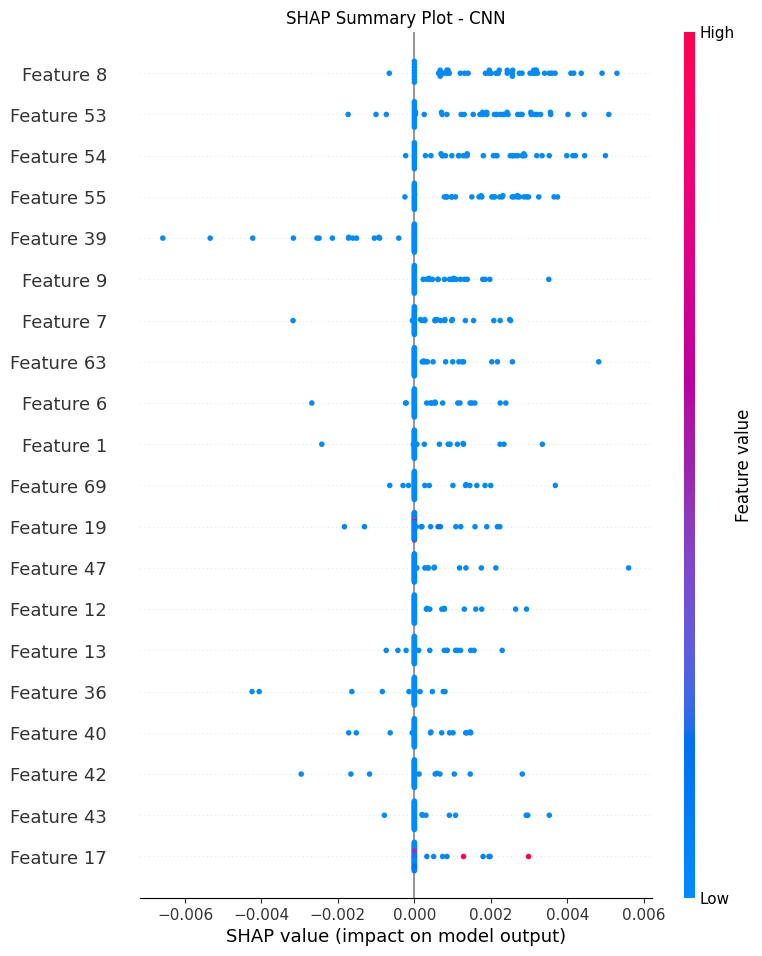

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# === SHAP for XGBoost ===
try:
    # Use the trained model's booster directly
    explainer = shap.TreeExplainer(xgb.get_booster())
    shap_values = explainer.shap_values(X_test[:200])

    # SHAP summary plot
    shap.summary_plot(shap_values, X_test[:200], show=False)
    plt.title("SHAP Summary Plot - XGBoost")
    plt.show()

except Exception as e:
    print("SHAP XGBoost skipped:", e)

# === SHAP for CNN using KernelExplainer ===
try:
    background = shap.sample(X_train[:500], 100)
    f = lambda inp: cnn_model.predict(np.expand_dims(inp, axis=2), verbose=0).flatten()
    explainer_cnn = shap.KernelExplainer(f, background)
    shap_vals = explainer_cnn.shap_values(X_test[:50], nsamples=50)

    shap.summary_plot(shap_vals, X_test[:50], show=False)
    plt.title("SHAP Summary Plot - CNN")
    plt.show()

except Exception as e:
    print("SHAP CNN skipped:", e)

# === LIME ===
try:
    from lime import lime_tabular
    LIME_AVAILABLE = True
except ImportError:
    LIME_AVAILABLE = False
    print("LIME not installed, skipping LIME section...")

if LIME_AVAILABLE:
    try:
        feature_names = df.drop(columns=[target]).columns.tolist()

        explainer = lime_tabular.LimeTabularExplainer(
            training_data=np.array(X_train),
            feature_names=feature_names,
            class_names=['Normal', 'Attack'],
            discretize_continuous=True
        )

        exp = explainer.explain_instance(
            X_test[0],
            xgb.predict_proba,
            num_features=10
        )
        exp.show_in_notebook(show_table=True)

    except Exception as e:
        print("LIME skipped:", e)
